In [1]:
import pandas as pd
from pathlib import Path

path = Path("..")

file = next(path.rglob("**/LAEI_2019_NA_FILLED_WITH_MEAN.csv"))
dataframe = pd.read_csv(file)

# Check the first few rows of each dataset
print("Data with Mean Imputation:\n", dataframe.head())

Data with Mean Imputation:
    Year              Sector          nox         n2o         pm10  \
0  2013    Accidental Fires    21.129667   56.586259    84.125344   
1  2013         Agriculture   244.437997  204.042963    29.984091   
2  2013            Aviation  3851.256755   56.586259    69.838248   
3  2013             Biomass  1586.319624   56.586259  1054.000324   
4  2013  Commercial Cooking  1586.319624   56.586259   547.828374   

         pm2.5           co2  
0    78.041130  9.550853e+05  
1    16.049516  6.776104e+03  
2    58.381094  1.054197e+06  
3  1054.000324  9.550853e+05  
4   547.828374  9.550853e+05  


In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Load the dataset
dataframe = pd.read_csv(file)  # Replace with your file path

# Initialize the Label Encoder
encoder = LabelEncoder()

# Encode 'Sector' using Label Encoding
dataframe["Sector"] = encoder.fit_transform(dataframe["Sector"])

pollutants = ["nox", "n2o", "pm10", "pm2.5", "co2"]
models = {}
chart_data = []

for pol in pollutants:
    # Select features excluding the target pollutant
    X = dataframe[list(filter(lambda x: pol != x or pol.lower() in ("year", "sector"), dataframe.columns))]
    y = dataframe[pol]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=15)
    
    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Best model from grid search
    best_model = grid_search.best_estimator_
    
    # Fit the best model on the training data
    best_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    test_score = best_model.score(X_test, y_test)
    print(f'{pol} Test R^2 Score: {test_score}')
    
    # Make predictions and prepare data for comparison
    X_test[f'{pol}_pred'] = best_model.predict(X_test)
    X_test[pol] = y_test
    chart_data.append(X_test[[col for col in X_test.columns if col.startswith(pol) or col == 'Year']])
    
    # Store the model
    models[pol] = {"model": best_model}

nox Test R^2 Score: 0.9173371428541466
n2o Test R^2 Score: 0.9809150479819253
pm10 Test R^2 Score: 0.9569544671584286
pm2.5 Test R^2 Score: 0.875663055426568
co2 Test R^2 Score: 0.9534712551341081


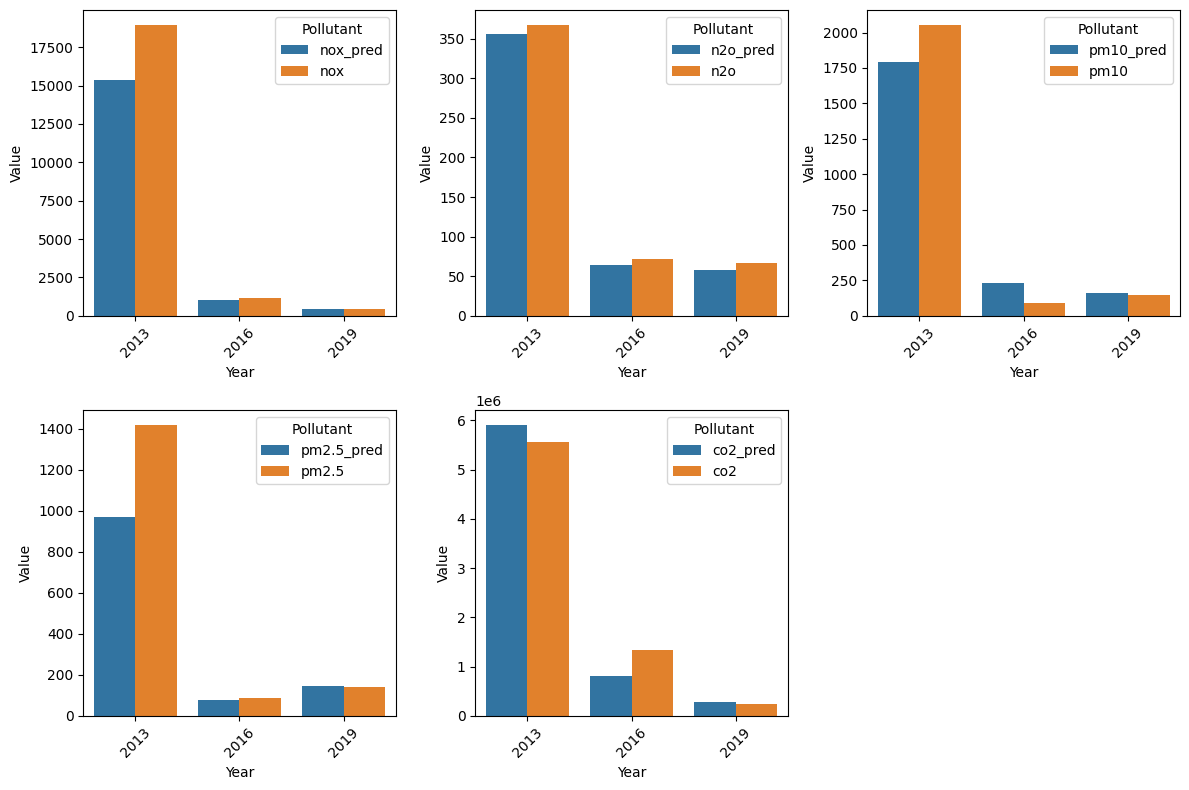

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a grid of subplots
num_pollutants = len(pollutants)
cols = 3  # Number of columns
rows = 2  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, pollutant in enumerate(chart_data):
    # Melt the DataFrame for Seaborn
    melted_df = pollutant.melt(id_vars=["Year"], var_name="Pollutant", value_name="Value")
    
    # Create the bar plot
    sns.barplot(data=melted_df, x="Year", y="Value", hue="Pollutant", ax=axes[i], errorbar=None)
    
    # Customize the plot
    # axes[i].set_title(f'Comparison of {pollutant.upper()} Levels by Year')
    axes[i].set_xlabel('Year')
    # axes[i].set_ylabel(f'{pollutant.upper()} Levels')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()